In [31]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution2D, Deconvolution2D, Flatten, Dense, BatchNormalization, Activation, Reshape, LeakyReLU
from pvlib.solarposition import get_solarposition
from keras.layers.core import K
from keras.optimizers import Adam


In [22]:
128  * 156

19968

In [2]:
tsi_data = xr.open_mfdataset("/scratch/dgagne/arm_tsi_sgp_nc/*.nc", )

In [13]:
tsi_times = pd.DatetimeIndex(tsi_data["time"].values)

In [16]:
sgp_lat = 36.605
sgp_lon = -97.485
altitude = 318
tsi_solpos = get_solarposition(tsi_times, sgp_lat, sgp_lon, alitude=altitude)

In [17]:
tsi_solpos

,apparent_elevation,apparent_zenith,azimuth,elevation,equation_of_time,zenith
2014-01-01 13:47:00,0.488056,89.511944,119.101002,0.008030,-3.576281,89.991970
2014-01-01 13:47:30,0.563242,89.436758,119.175539,0.095667,-3.576445,89.904333
2014-01-01 13:48:00,0.638762,89.361238,119.250150,0.183240,-3.576609,89.816760
2014-01-01 13:48:30,0.714614,89.285386,119.324837,0.270750,-3.576773,89.729250
2014-01-01 13:49:00,0.790796,89.209204,119.399599,0.358195,-3.576937,89.641805
2014-01-01 13:49:30,0.867301,89.132699,119.474437,0.445577,-3.577101,89.554423
2014-01-01 13:50:00,0.944121,89.055879,119.549351,0.532893,-3.577265,89.467107
2014-01-01 13:50:30,1.021248,88.978752,119.624342,0.620145,-3.577428,89.379855
2014-01-01 13:51:00,1.098671,88.901329,119.699410,0.707332,-3.577592,89.292668
2014-01-01 13:51:30,1.176380,88.823620,119.774554,0.794454,-3.577756,89.205546


In [19]:
tsi_patch = tsi_data["tsi_image"][:, 100:228, 280:280+128]

In [141]:
t_size = 4864
b_size = 256
n_epochs = 100
K.set_learning_phase(0)
opt = Adam(lr= 0.0002, beta_1=0.5)
dopt = Adam(lr= 0.0002, beta_1=0.5)
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
        
def generator_model(batch_size):
    model = Sequential()
    model.add(Dense(input_shape=(100,), output_dim=512 * 2 * 2))
    model.add(Reshape((2, 2, 512)))
    model.add(Deconvolution2D(256, 5, 5, output_shape=(batch_size, 4, 4, 256), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))    
    model.add(Deconvolution2D(128, 5, 5, output_shape=(batch_size, 8, 8, 128), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Deconvolution2D(64, 5, 5, output_shape=(batch_size, 16, 16, 64), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Deconvolution2D(32, 5, 5, output_shape=(batch_size, 32, 32, 32), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Deconvolution2D(16, 5, 5, output_shape=(batch_size, 64, 64, 16), subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Deconvolution2D(3, 5, 5, output_shape=(batch_size, 128, 128, 3), subsample=(2,2), border_mode="same"))
    model.add(Activation("tanh"))
    return model

def discriminator_model():
    model = Sequential()
    model.add(Convolution2D(16, 5, 5, subsample=(2,2), input_shape=(128, 128, 3), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(32, 5, 5, subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(64, 5, 5, subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(128, 5, 5, subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(256, 5, 5, subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(512, 5, 5, subsample=(2,2), border_mode="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    return model

def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    make_trainable(discriminator, False)
    model.add(discriminator)
    return model


In [24]:
train_data = tsi_patch[:19968].values

In [52]:
train_data_small = train_data[:19456][::4]

In [56]:
train_data_small.shape[0]

4864

In [102]:
train_data_scaled = 2 * ((train_data_small - train_data_small.min()) / (train_data_small.max() - train_data_small.min())) - 1

In [154]:
disc = discriminator_model()
gen = generator_model(b_size * 2)
gen.compile(loss="binary_crossentropy", optimizer=opt)
print(gen.summary())
print(disc.summary())
disc.compile(loss='binary_crossentropy', optimizer=dopt, metrics=["accuracy"])
#disc_on_gen = generator_containing_discriminator(gen, disc)
#disc_on_gen.compile(loss="binary_crossentropy", 
#                       optimizer=opt,
#                       metrics=["accuracy"])
sample_images = np.zeros(np.concatenate([[n_epochs], train_data_scaled.shape[1:]]))
g_loss = np.zeros((n_epochs, 2))
d_loss = np.zeros((n_epochs, 2))
train_order = np.arange(t_size)
for ep in range(0, n_epochs):
    print("Epoch ", ep)
    np.random.shuffle(train_order)
    for b in range(t_size // b_size):
        noise = np.random.uniform(-1, 1, size=(b_size * 2, 100)).astype(np.float32)
        train_noise = gen.predict(noise, batch_size=b_size * 2)[::2]
        if b == 0:
            sample_images[ep] = train_noise[0]
        combo_data = np.vstack([train_noise, train_data_scaled[train_order[b * b_size: (b + 1) * b_size]]])
        combo_labels = np.ones((combo_data.shape[0]), dtype=float)
        combo_labels[b_size:] = 0
        #combo_labels[b_size:, 1] = 1
        d_loss[ep] += disc.train_on_batch(combo_data, combo_labels)

        #print("Disc loss", d_loss)
        #if b == 0 and ep == 1:
        disc_on_gen = generator_containing_discriminator(gen, disc)
        disc_on_gen.compile(loss="binary_crossentropy", 
                        optimizer=opt,
                        metrics=["accuracy"])
        if ep > 0:
            make_trainable(disc, False)
            #gen.compile(loss="binary_crossentropy", optimizer=opt)
            #disc.compile(loss='binary_crossentropy', optimizer=dopt, metrics=["accuracy"])
            #disc_on_gen.compile(loss="binary_crossentropy", 
            #           optimizer=opt,
            #           metrics=["accuracy"])
            g_loss[ep] += disc_on_gen.train_on_batch(noise, np.zeros(b_size * 2))
            #print("Gen loss", g_loss)
            make_trainable(disc, True)
            #gen.compile(loss="binary_crossentropy", optimizer=opt)
            disc.compile(loss='binary_crossentropy', optimizer=dopt, metrics=["accuracy"])
            #disc_on_gen.compile(loss="binary_crossentropy", 
            #           optimizer=opt,
            #           metrics=["accuracy"])
    d_loss[ep] /= t_size // b_size
    g_loss[ep] /= t_size // b_size
    print(d_loss[ep], g_loss[ep], pd.Timestamp("now"))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_28 (Dense)                 (None, 2048)          206848      dense_input_14[0][0]             
____________________________________________________________________________________________________
reshape_14 (Reshape)             (None, 2, 2, 512)     0           dense_28[0][0]                   
____________________________________________________________________________________________________
deconvolution2d_79 (Deconvolutio (None, 4, 4, 256)     3277056     reshape_14[0][0]                 
____________________________________________________________________________________________________
batchnormalization_151 (BatchNor (None, 4, 4, 256)     1024        deconvolution2d_79[0][0]         
___________________________________________________________________________________________

InvalidArgumentError: You must feed a value for placeholder tensor 'dense_input_14' with dtype float
	 [[Node: dense_input_14 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'dense_input_14', defined at:
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-154-822ed95f20f3>", line 2, in <module>
    gen = generator_model(b_size * 2)
  File "<ipython-input-141-e6391527f26a>", line 14, in generator_model
    model.add(Dense(input_shape=(100,), output_dim=512 * 2 * 2))
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-1.2.0-py3.5.egg/keras/models.py", line 299, in add
    layer.create_input_layer(batch_input_shape, input_dtype)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-1.2.0-py3.5.egg/keras/engine/topology.py", line 397, in create_input_layer
    dtype=input_dtype, name=name)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-1.2.0-py3.5.egg/keras/engine/topology.py", line 1198, in Input
    input_tensor=tensor)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-1.2.0-py3.5.egg/keras/engine/topology.py", line 1116, in __init__
    name=self.name)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/Keras-1.2.0-py3.5.egg/keras/backend/tensorflow_backend.py", line 309, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1526, in placeholder
    name=name)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'dense_input_14' with dtype float
	 [[Node: dense_input_14 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [109]:
sample_images.min()

-0.99999833106994629

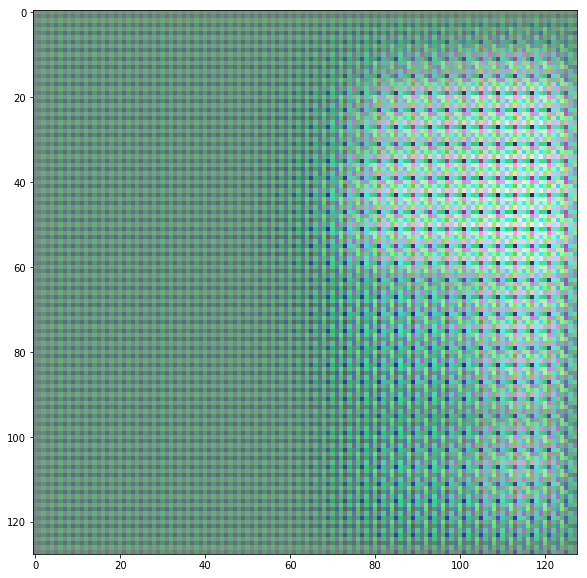

In [153]:
plt.figure(figsize=(10, 10))
plt.imshow(((sample_images[-80] + 1) / 2 * 255).astype("uint8") )

In [125]:
train_noise.shape

(256, 128, 128, 3)

In [133]:
training_order = np.arange(t_size)

In [140]:
np.random.shuffle(training_order)
training_order

array([ 707, 1477, 3850, ..., 1223, 4657, 3562])